In [32]:
from diff_predictor import data_process, predxgboost
from diff_classifier import pca
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale, StandardScaler
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from os import listdir, getcwd, chdir
from os.path import isfile, join


In [3]:
workbookDir = getcwd()

print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor


In [4]:
age_dataset_path = workbookDir + '/data/raw_data_age/'
age_filelist = [f for f in listdir(age_dataset_path) if isfile(join(age_dataset_path, f)) and 'feat' in f]
print(len(age_filelist))

region_dataset_path = workbookDir + '/data/region_feature_folder/'
region_filelist = [f for f in listdir(region_dataset_path) if isfile(join(region_dataset_path, f)) and 'feat' in f]
print(len(region_filelist))

treatment_dataset_path = workbookDir + '/data/ecm_feature_folder/'
treatment_filelist = [f for f in listdir(treatment_dataset_path) if isfile(join(treatment_dataset_path, f)) and 'msd' in f]
print(len(treatment_filelist))

75
38
180


In [25]:
features = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
#     'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    #'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    #'angle_mag_mean', # Magnitude of the turning angle mean
    #'angle_var', # Variance of the turning angle
    #'dist_tot', # Total distance of the trajectory
    #'dist_net', # Net distance from first point to last point
    #'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

In [243]:
mean_features = [
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2'
    ]

In [ ]:
fstats_tot_age = data_process.generate_fullstats(age_dataset_path, age_filelist, ['P14','NT', 'P70'], 'age')

In [65]:

ecm = fstats_tot_age[features + ['age', 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(features) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(38790, 36)


(33737, 36)

In [51]:
ecm = ecm.fillna(0)

In [28]:
dropped = ecm.dropna()
dropped.shape

(33737, 36)

In [66]:
labels = np.array(ecm['age'])
features_df = ecm.drop(['age', 'X', 'Y', 'Track_ID'], axis=1)
col_names = features_df.columns

In [107]:
ghyh = labels=='NT'
ghyh

array([False, False, False, ...,  True,  True,  True])

In [111]:
len(pca_embeddings[ghyh, 0:2])

14869

In [54]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(features_df)
scaled_df = pd.DataFrame(scaled_df, columns=features)

In [77]:
pca = PCA(n_components=10).fit(scaled_df)
pca.explained_variance_ratio_.sum()
pca_embeddings = pca.transform(scaled_df)
pca_embeddings_df = pd.DataFrame(pca_embeddings[:, :2], columns=['Component 1', 'Component 2'])
pca_embeddings_df['target'] = labels

In [102]:
index = pca_embeddings_df.index
class_inds = index[pca_embeddings_df['target'] == 'P70']

In [103]:
class_inds

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            28172, 28173, 28174, 28175, 28176, 28177, 28178, 28179, 28180,
            28181],
           dtype='int64', length=13968)

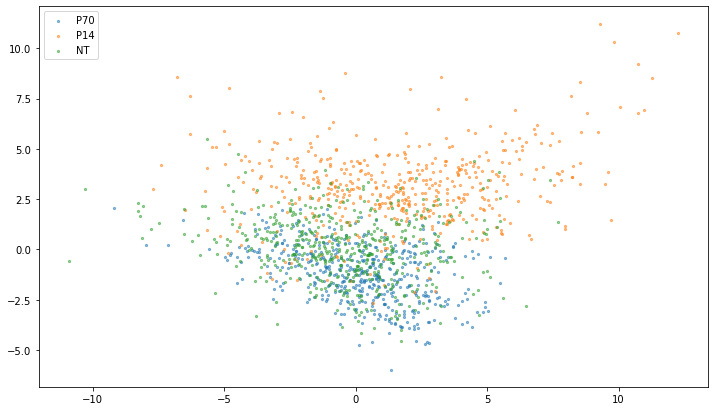

In [87]:
fig = plt.figure(figsize=(12,7))
for uclass in pca_embeddings_df['target'].unique():
    df = pca_embeddings_df[pca_embeddings_df['target'] == uclass].sample(500)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.5, s=5, label=uclass)
plt.legend()
    

In [163]:
def myplot(score,coeff,labels=None, targets=None, num_points='all'):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    for uclass in np.unique(targets):
        x = (xs[targets==uclass])*scalex
        y = (ys[targets==uclass])*scaley
        if num_points == 'all':
            plt.scatter(x, y, alpha=0.5, s=1)
        else:
            inds = np.random.randint(0, len(x), num_points)
            plt.scatter(x[inds], y[inds], alpha=0.5, s=1)
    #plt.scatter(xs * scalex,ys * scaley)#, c = y)
    for i in range((n//2), n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0], coeff[i,1], labels[i], color = 'k', ha = 'center', va = 'center')
    plt.xlim(-0.6,.6)
    plt.ylim(-.6,.6)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

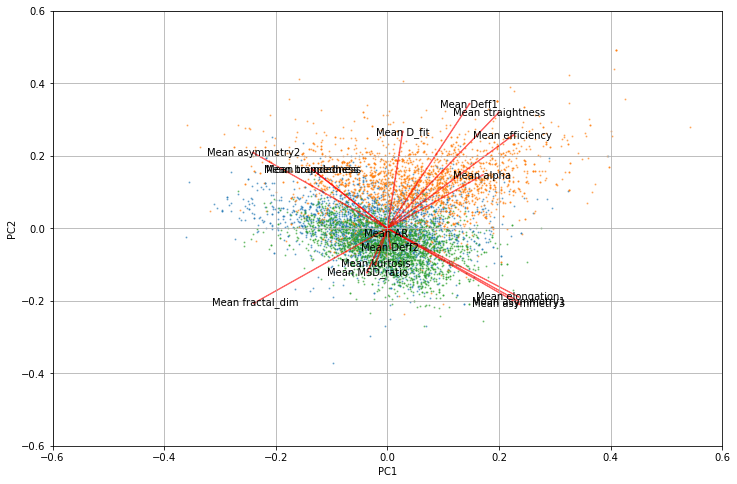

In [167]:
fig = plt.figure(figsize=(12,8))
myplot(pca_embeddings[:,0:2],np.transpose(pca.components_[0:2, :]), labels=col_names, targets=labels, num_points=2500)
plt.show()

In [185]:
X_embedded = TSNE(n_components=2, n_jobs=-1, learning_rate=11, init='pca', random_state=42).fit_transform(scaled_df)
tsne_embeddings_df = pd.DataFrame(X_embedded, columns=['Component 1', 'Component 2'])
tsne_embeddings_df['target'] = labels

(-20.0, 20.0)

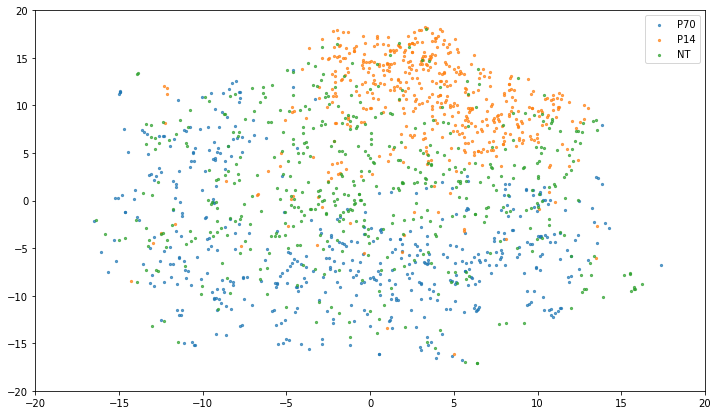

In [196]:
fig = plt.figure(figsize=(12,7))
for uclass in tsne_embeddings_df['target'].unique():
    df = tsne_embeddings_df[tsne_embeddings_df['target'] == uclass].sample(500)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.7, s=5, label=uclass)
plt.legend()
plt.ylim([-20,20])
plt.xlim([-20,20])

In [247]:
ecm = fstats_tot_age[mean_features + ['age', 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(mean_features) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

ecm = ecm.fillna(0)

labels = np.array(ecm['age'])
features_df = ecm.drop(['age', 'X', 'Y', 'Track_ID'], axis=1)
col_names = features_df.columns

scaler = StandardScaler()
scaled_df = scaler.fit_transform(features_df)
scaled_df = pd.DataFrame(scaled_df, columns=col_names)

(38790, 20)


In [254]:
pca = PCA(n_components=2).fit(scaled_df)
print(pca.explained_variance_ratio_.sum())
pca_embeddings = pca.transform(scaled_df)
pca_embeddings_df = pd.DataFrame(pca_embeddings[:, :2], columns=['Component 1', 'Component 2'])
pca_embeddings_df['target'] = labels

0.5011389276791496


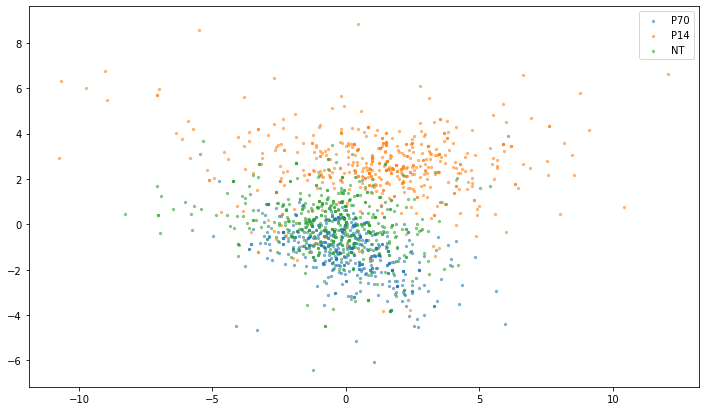

In [255]:
fig = plt.figure(figsize=(12,7))
for uclass in pca_embeddings_df['target'].unique():
    df = pca_embeddings_df[pca_embeddings_df['target'] == uclass].sample(500)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.5, s=5, label=uclass)
plt.legend()

In [257]:
X_embedded = TSNE(n_components=2, n_jobs=-1, learning_rate=250, init='pca', random_state=42).fit_transform(scaled_df)
tsne_embeddings_df = pd.DataFrame(X_embedded, columns=['Component 1', 'Component 2'])
tsne_embeddings_df['target'] = labels

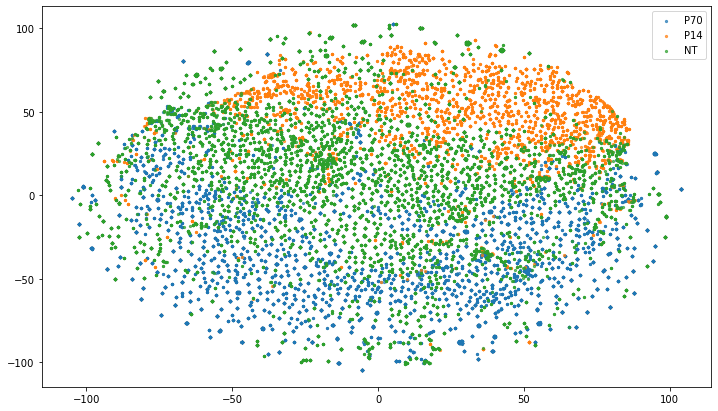

In [260]:
fig = plt.figure(figsize=(12,7))
for uclass in tsne_embeddings_df['target'].unique():
    df = tsne_embeddings_df[tsne_embeddings_df['target'] == uclass]#.sample(500)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.7, s=5, label=uclass)
plt.legend()
#plt.ylim([-20,20])
#plt.xlim([-20,20])

In [262]:
ecm = fstats_tot_age[features + ['age', 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(features) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm = ecm[ecm['alpha'] > 1.25]
ecm = ecm.fillna(0)
print(ecm.shape)

labels = np.array(ecm['age'])
features_df = ecm.drop(['age', 'X', 'Y', 'Track_ID'], axis=1)
col_names = features_df.columns

scaler = StandardScaler()
scaled_df = scaler.fit_transform(features_df)
scaled_df = pd.DataFrame(scaled_df, columns=col_names)

(38790, 36)
(7535, 36)


In [272]:
X_embedded = TSNE(n_components=2, n_jobs=-1, learning_rate=1000, init='pca', random_state=42).fit_transform(scaled_df)
tsne_embeddings_df = pd.DataFrame(X_embedded, columns=['Component 1', 'Component 2'])
tsne_embeddings_df['target'] = labels

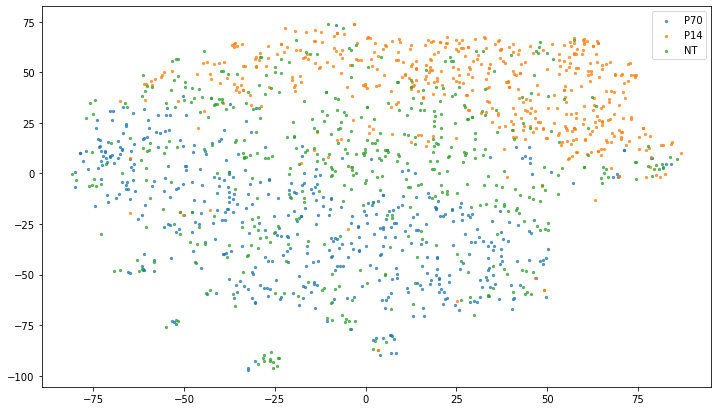

In [273]:
fig = plt.figure(figsize=(12,7))
for uclass in tsne_embeddings_df['target'].unique():
    df = tsne_embeddings_df[tsne_embeddings_df['target'] == uclass].sample(500)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.7, s=5, label=uclass)
plt.legend()
#plt.ylim([-20,20])
#plt.xlim([-20,20])

In [264]:
pca = PCA(n_components=10).fit(scaled_df)
print(pca.explained_variance_ratio_.sum())
pca_embeddings = pca.transform(scaled_df)
pca_embeddings_df = pd.DataFrame(pca_embeddings[:, :2], columns=['Component 1', 'Component 2'])
pca_embeddings_df['target'] = labels

0.7866997125821202


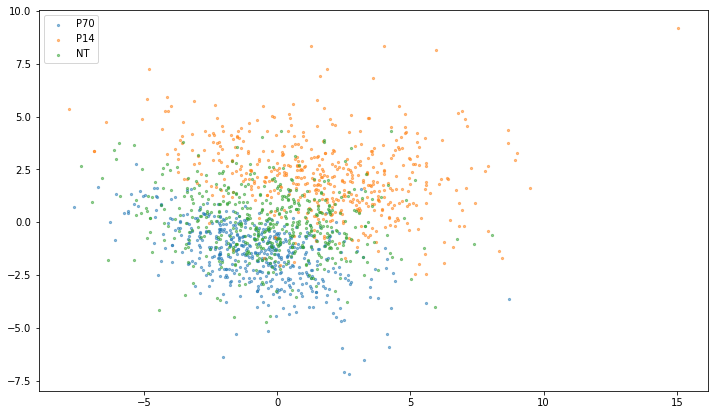

In [268]:
fig = plt.figure(figsize=(12,7))
for uclass in pca_embeddings_df['target'].unique():
    df = pca_embeddings_df[pca_embeddings_df['target'] == uclass].sample(500)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.5, s=5, label=uclass)
plt.legend()

# Region data

In [ ]:
fstats_tot_region = data_process.generate_fullstats(region_dataset_path, region_filelist, ['cortex', 'ganglia', 'hippocampus', 'thalamus', 'striatum'], 'region')

In [198]:
ecm = fstats_tot_region[features + ['region', 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(features) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(125416, 36)


(96085, 36)

In [199]:
ecm = ecm.fillna(0)

In [200]:
labels = np.array(ecm['region'])
features_df = ecm.drop(['region', 'X', 'Y', 'Track_ID'], axis=1)
col_names = features_df.columns

In [201]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(features_df)
scaled_df = pd.DataFrame(scaled_df, columns=features)

In [203]:
pca = PCA(n_components=10).fit(scaled_df)
pca.explained_variance_ratio_.sum()
pca_embeddings = pca.transform(scaled_df)
pca_embeddings_df = pd.DataFrame(pca_embeddings[:, :2], columns=['Component 1', 'Component 2'])
pca_embeddings_df['target'] = labels

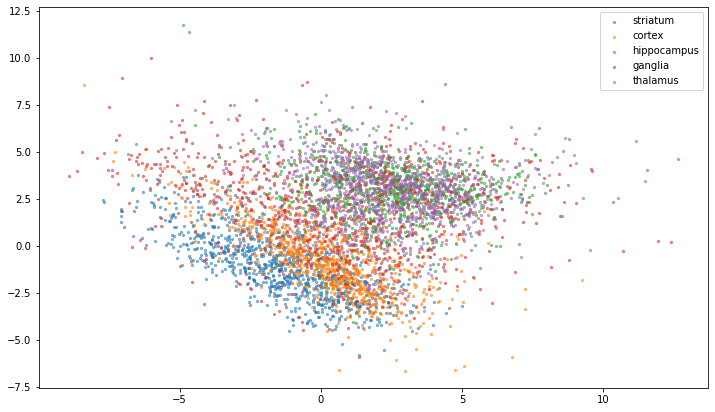

In [208]:
fig = plt.figure(figsize=(12,7))
for uclass in pca_embeddings_df['target'].unique():
    df = pca_embeddings_df[pca_embeddings_df['target'] == uclass].sample(1000)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.5, s=5, label=uclass)
plt.legend()
    

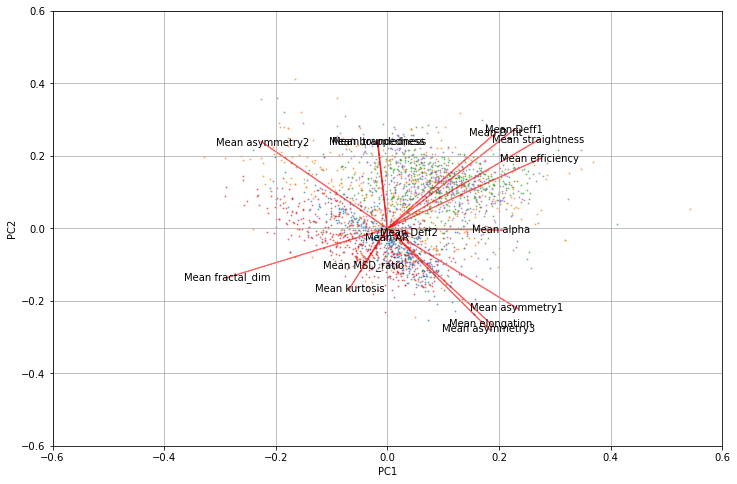

In [206]:
fig = plt.figure(figsize=(12,8))
myplot(pca_embeddings[:,0:2],np.transpose(pca.components_[0:2, :]), labels=col_names, targets=labels, num_points=500)
plt.show()

In [210]:
X_embedded = TSNE(n_components=2, n_jobs=-1, learning_rate=11, init='pca', random_state=42).fit_transform(scaled_df)
tsne_embeddings_df = pd.DataFrame(X_embedded, columns=['Component 1', 'Component 2'])
tsne_embeddings_df['target'] = labels

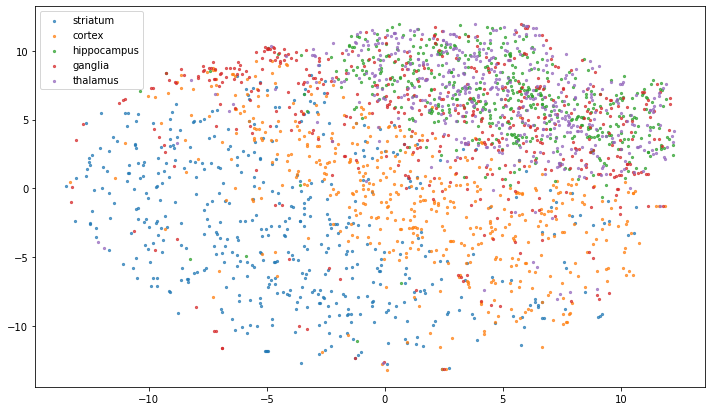

In [211]:
fig = plt.figure(figsize=(12,7))
for uclass in tsne_embeddings_df['target'].unique():
    df = tsne_embeddings_df[tsne_embeddings_df['target'] == uclass].sample(500)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.7, s=5, label=uclass)
plt.legend()
# plt.ylim([-20,20])
# plt.xlim([-20,20])

# Treatment data

In [ ]:
fstats_tot_treatment = data_process.generate_fullstats(treatment_dataset_path, treatment_filelist, ['NT', 'ChABC'], 'treatment')

In [213]:
ecm = fstats_tot_treatment[features + ['treatment', 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(features) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(142453, 36)


(117505, 36)

In [217]:
ecm = ecm.fillna(0)
labels = np.array(ecm['treatment'])
features_df = ecm.drop(['treatment', 'X', 'Y', 'Track_ID'], axis=1)
col_names = features_df.columns

scaler = StandardScaler()
scaled_df = scaler.fit_transform(features_df)
scaled_df = pd.DataFrame(scaled_df, columns=features)

In [218]:
pca = PCA(n_components=10).fit(scaled_df)
pca.explained_variance_ratio_.sum()
pca_embeddings = pca.transform(scaled_df)
pca_embeddings_df = pd.DataFrame(pca_embeddings[:, :2], columns=['Component 1', 'Component 2'])
pca_embeddings_df['target'] = labels

(-15.0, 15.0)

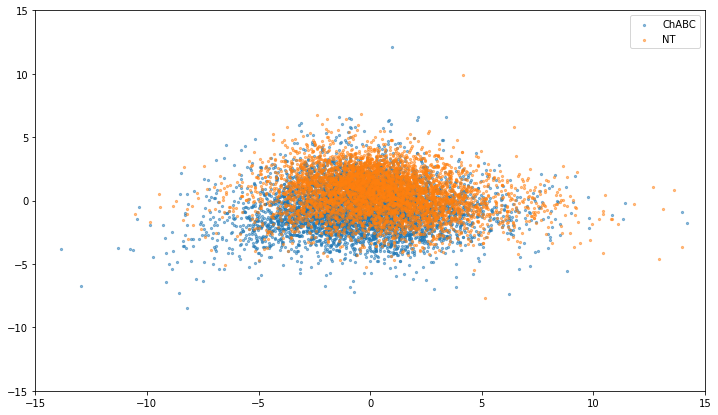

In [222]:
fig = plt.figure(figsize=(12,7))
for uclass in pca_embeddings_df['target'].unique():
    df = pca_embeddings_df[pca_embeddings_df['target'] == uclass].sample(5000)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.5, s=5, label=uclass)
plt.legend()
plt.xlim([-15,15])
plt.ylim([-15,15])

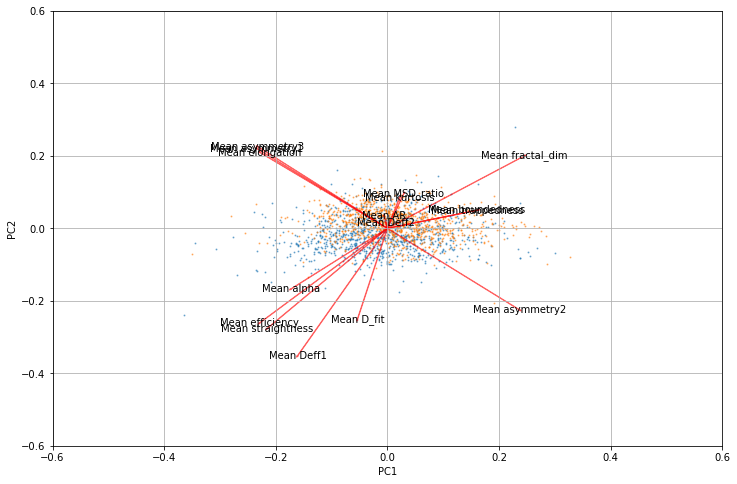

In [224]:
fig = plt.figure(figsize=(12,8))
myplot(pca_embeddings[:,0:2],np.transpose(pca.components_[0:2, :]), labels=col_names, targets=labels, num_points=1000)
plt.show()

In [235]:
X_embedded = TSNE(n_components=2, n_jobs=-1, learning_rate=700, init='pca', random_state=42).fit_transform(scaled_df)
tsne_embeddings_df = pd.DataFrame(X_embedded, columns=['Component 1', 'Component 2'])
tsne_embeddings_df['target'] = labels

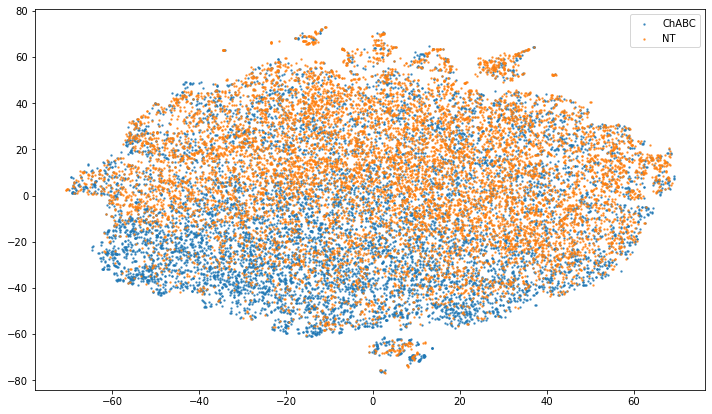

In [237]:
fig = plt.figure(figsize=(12,7))
for uclass in tsne_embeddings_df['target'].unique():
    df = tsne_embeddings_df[tsne_embeddings_df['target'] == uclass].sample(10000)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.7, s=2, label=uclass)
plt.legend()
#plt.ylim([-15,15])
#plt.xlim([-15,15])

(-15.0, 15.0)

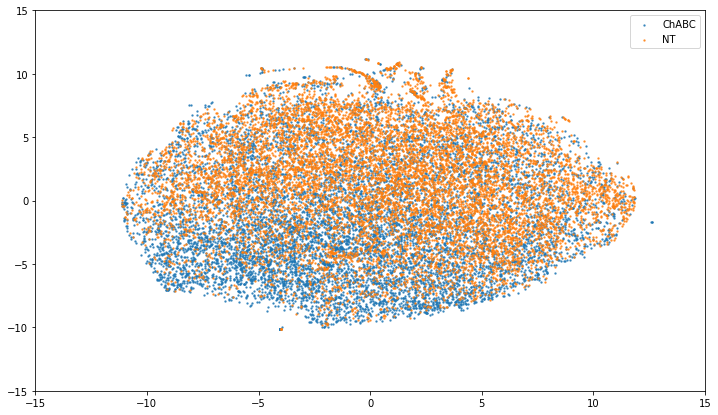

In [234]:
fig = plt.figure(figsize=(12,7))
for uclass in tsne_embeddings_df['target'].unique():
    df = tsne_embeddings_df[tsne_embeddings_df['target'] == uclass].sample(10000)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.7, s=2, label=uclass)
plt.legend()
plt.ylim([-15,15])
plt.xlim([-15,15])

In [238]:
X_embedded = TSNE(n_components=2, n_jobs=-1, learning_rate=250, init='pca', random_state=42).fit_transform(scaled_df)
tsne_embeddings_df = pd.DataFrame(X_embedded, columns=['Component 1', 'Component 2'])
tsne_embeddings_df['target'] = labels

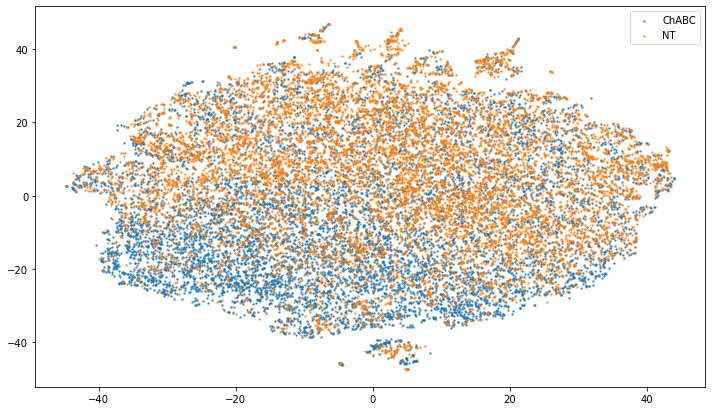

In [239]:
fig = plt.figure(figsize=(12,7))
for uclass in tsne_embeddings_df['target'].unique():
    df = tsne_embeddings_df[tsne_embeddings_df['target'] == uclass].sample(10000)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.7, s=2, label=uclass)
plt.legend()
#plt.ylim([-15,15])
#plt.xlim([-15,15])

In [241]:
X_embedded = TSNE(n_components=2, n_jobs=-1, learning_rate=1000, init='pca', random_state=42).fit_transform(scaled_df)
tsne_embeddings_df = pd.DataFrame(X_embedded, columns=['Component 1', 'Component 2'])
tsne_embeddings_df['target'] = labels

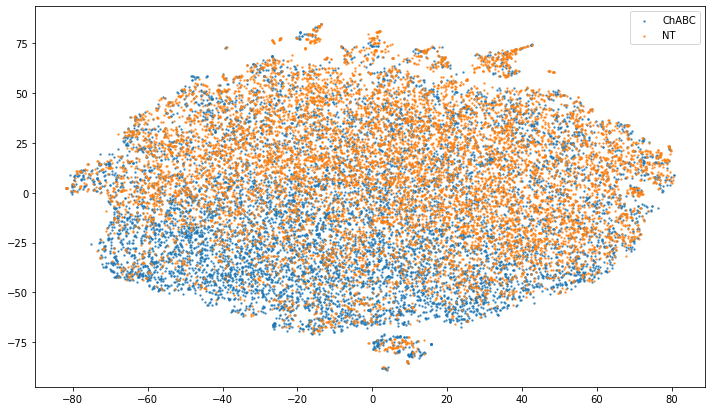

In [242]:
fig = plt.figure(figsize=(12,7))
for uclass in tsne_embeddings_df['target'].unique():
    df = tsne_embeddings_df[tsne_embeddings_df['target'] == uclass].sample(10000)
    x = df['Component 1']
    y = df['Component 2']
    plt.scatter(x,y, alpha=0.7, s=2, label=uclass)
plt.legend()
#plt.ylim([-15,15])
#plt.xlim([-15,15])